In [3]:
# %% ──────────────────────────────────────────────────────────
# Cell 0 – Imports & helpers
import numpy as np, pandas as pd, matplotlib.pyplot as plt, re
import pathlib, serial, time, datetime, warnings
from scipy.signal import butter, filtfilt, lfilter, find_peaks
from scipy.ndimage import median_filter


# ---------- hardware constants ----------
ADC_FS   = 4096         # 12-bit STM32
VREF     = 3.30         # ADC reference (V)
FS       = 77          # Sample-rate configured on MCU (Hz)

# ---------- condition registry ----------
CONDITIONS = {
    'rest'     : dict(target_bpm=7.8, notes='seated, relaxed'),
    'exercise' : dict(target_bpm=30, notes='after squats'),
    'talking'  : dict(target_bpm=16, notes='reading aloud'),
    'light'    : dict(target_bpm=15, notes='walking'),
    'jog'      : dict(target_bpm=22, notes='jogging on the spot')
}

# ---------- folders ----------
DATA_DIR = pathlib.Path("project3_data"); DATA_DIR.mkdir(exist_ok=True)
META_CSV = DATA_DIR / "meta_index.csv"

In [5]:
# %% ──────────────────────────────────────────────────────────
# Cell 1 – Capture two-channel stream for <duration> seconds
def acquire(cond='rest', port='COM7', baud=115200, duration=30):
    """Stream <adc1>,<adc2>\n from MCU, return t, vP, vS  (volts)."""
    if cond not in CONDITIONS:
        raise ValueError(f"Condition {cond} not in registry.")
    
    ser = serial.Serial(port, baud, timeout=1)

    raw1, raw2 = [], []
    t0 = time.time()

    pattern = re.compile(r'\[?CH1\s*=\s*(\d+)\s*CH2\s*=\s*(\d+)')

    while time.time() - t0 < duration:
        line = ser.readline().decode('utf-8', 'ignore').strip()
        m = pattern.match(line)
        if m:
            ch1 = int(m.group(1))
            ch2 = int(m.group(2))
            raw1.append(ch1)
            raw2.append(ch2)
            # comment out next line once things work
            print(f"[CH1={ch1}, CH2={ch2}]")

    ser.close()

    adcP = np.asarray(raw1, dtype=np.uint16)
    adcS = np.asarray(raw2, dtype=np.uint16)
    
    t    = np.arange(adcP.size) / FS
    vP   = adcP * VREF / ADC_FS
    vS   = adcS * VREF / ADC_FS
    print(f"Captured {adcP.size} samples  ({adcP.size/FS:.1f} s)")
    return t, vP, vS, adcP, adcS

In [ ]:
t, vP_raw, vS_raw, adcP, adcS = acquire(cond='talking', port='COM4', duration=60)

[CH1=2020, CH2=1240]
[CH1=2116, CH2=1198]
[CH1=1981, CH2=1185]
[CH1=1994, CH2=1205]
[CH1=2131, CH2=1224]
[CH1=2096, CH2=1204]
[CH1=2078, CH2=1170]
[CH1=2222, CH2=1210]
[CH1=2019, CH2=1192]
[CH1=1933, CH2=1185]
[CH1=1990, CH2=1180]
[CH1=2059, CH2=1178]
[CH1=2060, CH2=1168]
[CH1=1928, CH2=1177]
[CH1=2066, CH2=1147]
[CH1=1922, CH2=1208]
[CH1=1821, CH2=1187]
[CH1=1751, CH2=1197]
[CH1=1812, CH2=1205]
[CH1=1772, CH2=1197]
[CH1=1697, CH2=1178]
[CH1=1944, CH2=1180]
[CH1=1700, CH2=1209]
[CH1=1794, CH2=1219]
[CH1=1839, CH2=1228]
[CH1=1773, CH2=1198]
[CH1=1649, CH2=1168]
[CH1=1837, CH2=1197]
[CH1=1926, CH2=1200]
[CH1=1979, CH2=1211]
[CH1=1840, CH2=1222]
[CH1=1857, CH2=1196]
[CH1=1791, CH2=1211]
[CH1=1982, CH2=1169]
[CH1=1993, CH2=1241]
[CH1=2138, CH2=1197]
[CH1=2074, CH2=1165]
[CH1=2117, CH2=1177]
[CH1=2112, CH2=1184]
[CH1=1903, CH2=1158]
[CH1=2036, CH2=1200]
[CH1=2024, CH2=1163]
[CH1=1794, CH2=1175]
[CH1=1955, CH2=1200]
[CH1=2002, CH2=1161]
[CH1=2092, CH2=1138]
[CH1=2256, CH2=1178]
[CH1=2120, CH

In [6]:
# %% ──────────────────────────────────────────────────────────
# Cell 2 – Plot raw waveforms
def plot_waveforms(t, v1, v2, title='Captured ADC waveforms'):
    # Plot for Pressure (ch-1)
    plt.figure(figsize=(10,4))
    plt.plot(t, v1, label='Pressure (ch-1)')
    plt.xlabel('Time [s]')
    plt.ylabel('Voltage [V]')
    plt.title(f"{title} - Pressure")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot for Strap (ch-2)
    plt.figure(figsize=(10,4))
    plt.plot(t, v2, label='Strap (ch-2)', color='red')
    plt.xlabel('Time [s]')
    plt.ylabel('Voltage [V]')
    plt.title(f"{title} - Strap")
    plt.legend()
    plt.tight_layout()
    plt.show()

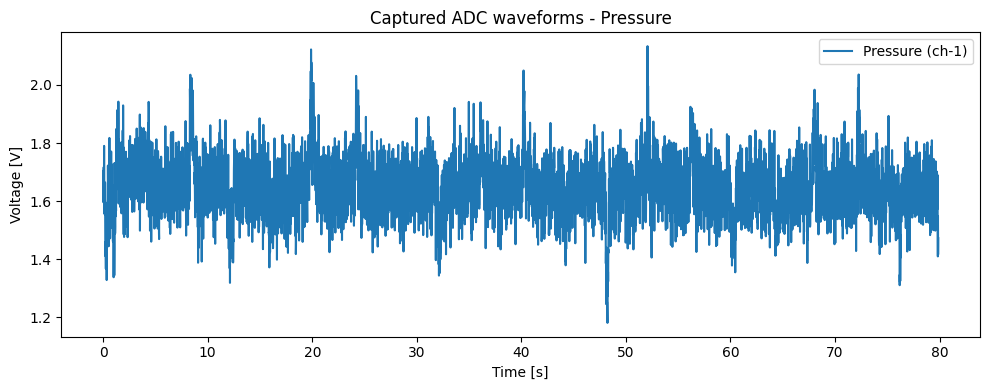

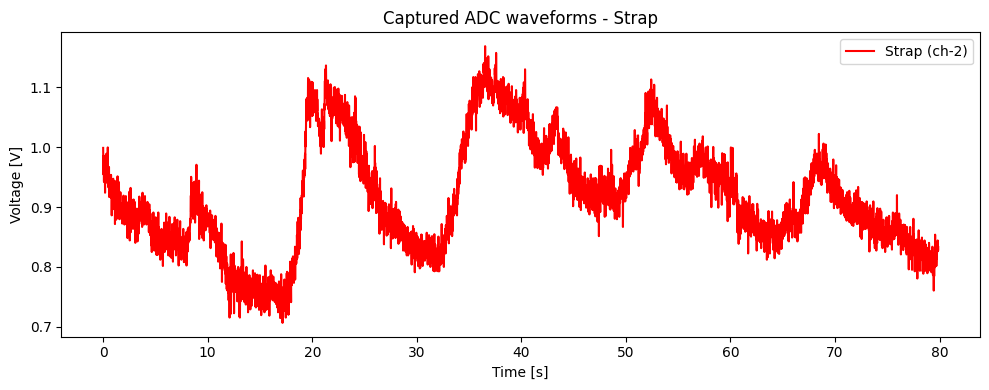

In [9]:
# Example live acquisition & plot  (comment if you only use saved files)
# t, vP, vS = acquire(port='COM4', duration=30)     # <-- change COM-port
plot_waveforms(t, vP_raw, vS_raw)

In [7]:
def breathing_band(target_bpm,  margin=0.6):
    """
    Return (f_lo, f_hi) in Hz given an *expected* breath-rate (BPM).

    margin <1  → narrower band
    margin >1  → wider band
    """
    f0   = target_bpm / 60            # centre frequency
    span = f0 * margin
    f_lo = max(0.02, f0 - span)       # keep above DC
    f_hi = f0 + span
    return f_lo, f_hi

In [43]:
# Example usage
cond = 'rest'  # Change to 'exercise', 'talking', etc. as needed
target_bpm = CONDITIONS[cond]['target_bpm']
f_lo, f_hi = breathing_band(target_bpm, margin=0.6)
print(f"Using band-pass {f_lo:.2f}–{f_hi:.2f} Hz for {cond}")

Using band-pass 0.03–0.10 Hz for rest


In [8]:
# %% ──────────────────────────────────────────────────────────
# Cell 3 – DSP toolbox: pick the block(s) you need
def safe_bandpass(x, fs=FS, f_lo=0.01, f_hi=0.5, order=2):
    b, a = butter(order, [f_lo, f_hi], fs=fs, btype="band")
    pad  = 3 * (max(len(a), len(b)) - 1)
    if len(x) > pad:
        return filtfilt(b, a, x, padtype="odd", padlen=pad)
    warnings.warn("Vector shorter than padlen ➜ using causal lfilter")
    return lfilter(b, a, x)

def moving_avg_compress(x, win=5, weighted=False):
    """
    Return a moving-average *same length as x*.

    Parameters
    ----------
    x    : 1-D array
    win  : int, window length (≥1)
    weighted : bool, use triangular weights if True

    Returns
    -------
    y    : 1-D array, len(y)==len(x)
    """
    if win <= 1:
        return x.copy()

    if weighted:
        w = np.arange(1, win+1)          # 1,2,…,win  (triangular)
        kernel = np.r_[w, w[-2::-1]]     # up & down
        kernel = kernel / kernel.sum()
        pad = len(kernel)//2
    else:
        kernel = np.ones(win) / win
        pad = win//2

    # zero-pad symmetrically to avoid edge shrinkage
    x_pad = np.pad(x, pad, mode='edge')
    y     = np.convolve(x_pad, kernel, mode='valid')
    return y


def linear_cal(x, m=1.0, c=0.0):
    return m * x + c

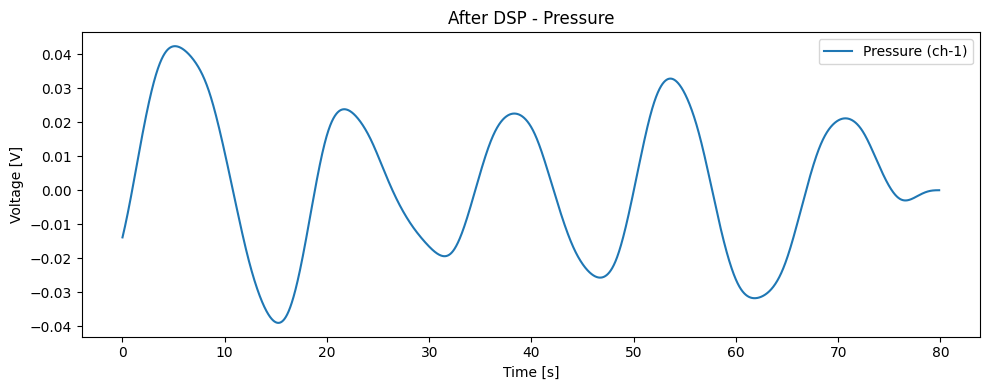

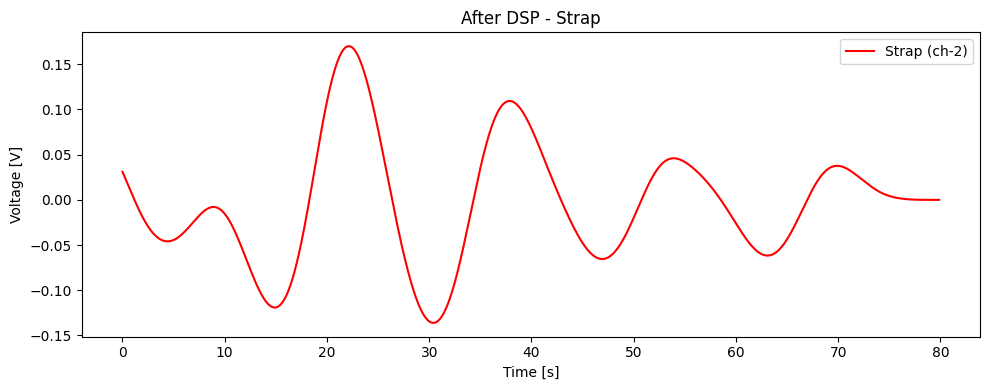

In [17]:
# %% ──────────────────────────────────────────────────────────
# Cell 4 – Load a recording, apply *one or more* DSP stages & re-plot
# ---------- choose DSP chain ----------
# vP = safe_bandpass(vP_raw)                 # noise-reduction
# vS = safe_bandpass(vS_raw)
vP = safe_bandpass(vP_raw, FS, f_lo, f_hi)
vS = safe_bandpass(vS_raw, FS, f_lo, f_hi)

# vP = moving_avg_compress(vP)             # optional compression demo
# vS = moving_avg_compress(vS)             # optional compression demo

# vP = linear_cal(vP, m=1.02) # optional gain tweak
# vS = linear_cal(vS, m=1.02) # optional gain tweak

# --------------------------------------
plot_waveforms(t[:len(vP)], vP, vS, title='After DSP')


In [9]:
# --------- SNR-weighted fusion ------------------------------------------
def fuse_bpm(t1, bpm1, t2, bpm2, win=3):
    t0, tf = max(t1[0], t2[0]), min(t1[-1], t2[-1])
    tc     = np.arange(t0, tf, 1)                 # 1 Hz grid
    b1     = np.interp(tc, t1, bpm1)
    b2     = np.interp(tc, t2, bpm2)
    var1   = pd.Series(b1).rolling(win, center=True)\
                          .var().bfill().ffill()
    var2   = pd.Series(b2).rolling(win, center=True)\
                          .var().bfill().ffill()
    w1     = var2 / (var1 + var2 + 1e-9)
    return tc, w1*b1 + (1-w1)*b2

In [10]:
# %% ──────────────────────────────────────────────────────────
# Cell 5 – Breath-rate extraction, fusion, and debug overlay
def breath_rate(sig, *,
                invert=False,
                bpm_max=34,          
                prominence=0.02,
                fs=FS,
                smooth=True,
                return_idx=False):
    """
    Detect peaks/valleys → breaths → BPM series.

    Returns (tbpm, bpm [, idx]) where
        tbpm  – timestamp (s) of each BPM value
        bpm   – breaths-per-min series
        idx   – indices of detected events (optional)

    If fewer than two events are found, returns empty arrays.
    """
    min_int = 60 / bpm_max                # s
    idx, _  = find_peaks(-sig if invert else sig,
                         #distance=int(min_int * fs),
                         prominence=prominence)

    if idx.size < 2:                      # not enough events
        if return_idx:
            return np.array([]), np.array([]), idx
        return np.array([]), np.array([])

    ibi  = np.diff(idx) / fs              # inter-breath interval [s]
    bpm  = 60 / ibi
    tbpm = idx[1:] / fs

    if smooth and bpm.size >= 3:          # 3-point median to kill spikes
        bpm = median_filter(bpm, size=3)

    if return_idx:
        return tbpm, bpm, idx
    return tbpm, bpm

In [ ]:
# --------- get BPM streams & event indices ------------------------------
tP, bpmP, idxP = breath_rate(vP, invert=False,  return_idx=True)   # valleys (invert=False for peaks)
tS, bpmS, idxS = breath_rate(vS, invert=True, return_idx=True)   # valleys

if bpmP.size == 0 or bpmS.size == 0:
    raise RuntimeError("Not enough breath events detected – "
                       "tune prominence/distance or record longer.")

tF, bpmF = fuse_bpm(tP, bpmP, tS, bpmS)

# --------- debug overlay for pressure channel ---------------------------
plt.figure(figsize=(10,3))
plt.plot(t, vP, label='Pressure DSP')
plt.scatter(t[idxP], vP[idxP], color='k', zorder=3,
            label='Detected breaths')
plt.xlabel('Time [s]'); plt.ylabel('Voltage [V]')
plt.title('Breath events on Pressure trace')
plt.legend(); plt.tight_layout(); plt.show()

print(f"Detected breaths (pressure): {idxP.size}")
if idxP.size >= 2:
    mean_bpm = 60 / np.diff(idxP/FS).mean()
    print(f"Mean BPM (pressure)      : {mean_bpm:.2f}")

# --------- debug overlay for strap channel ---------------------------
plt.figure(figsize=(10,3))
plt.plot(t, vS, label='Strap DSP', color = 'red')
plt.scatter(t[idxS], vS[idxS], color='k', zorder=3,
            label='Detected breaths')
plt.xlabel('Time [s]'); plt.ylabel('Voltage [V]')
plt.title('Breath events on Strap trace')
plt.legend(); plt.tight_layout(); plt.show()

print(f"Detected breaths (Strap): {idxS.size}")
if idxS.size >= 2:
    mean_bpm = 60 / np.diff(idxS/FS).mean()
    print(f"Mean BPM (strap)      : {mean_bpm:.2f}")
    
# --------- visualise BPM streams & fusion -------------------------------
plt.figure(figsize=(8,4))
plt.plot(tP, bpmP, '.-', label='Pressure BPM')
plt.plot(tS, bpmS, '.-', label='Strap BPM')
plt.plot(tF, bpmF,  'k', lw=2, label='Fused BPM')
plt.xlabel('Time [s]'); plt.ylabel('BPM'); plt.legend(); plt.tight_layout()
plt.show()

# summary numbers for the fusion track ─────────────────────────
if bpmF.size:
    mean_bpmF = bpmF.mean()
    print(f"Mean BPM   (fusion)     : {mean_bpmF:.2f}")
# ───────────────────────────────────────────────────────────────────────

In [ ]:
# ---------- metrics ----------
target = CONDITIONS[cond]["target_bpm"]
mseP = np.mean((bpmP - target)**2)
mseS = np.mean((bpmS - target)**2)
mseF = np.mean((bpmF - target)**2)
print(f"MSE  P:{mseP:.2f}  S:{mseS:.2f}  Fused:{mseF:.2f}")

In [11]:
# %% ──────────────────────────────────────────────────────────
# Cell 6 – Performance evaluation (MSE + optional JND)
# %% ──────────────────────────────────────────────────────────
# Cell 4 | One-click trial (record → DSP → fusion → save)
def run_trial(cond="rest", port="COM4", duration=60,
              dsp_chain=None, save=True, baud=115200):
    
    if cond not in CONDITIONS:
        raise ValueError("Unknown condition")
    dsp_chain = dsp_chain or [safe_bandpass]

    # ---------- acquire ----------
    print("acquiring...")
    ser = serial.Serial(port, baud, timeout=1)

    raw1, raw2 = [], []
    t0 = time.time()

    pattern = re.compile(r'\[?CH1\s*=\s*(\d+)\s*CH2\s*=\s*(\d+)')

    while time.time() - t0 < duration:
        line = ser.readline().decode('utf-8', 'ignore').strip()
        m = pattern.match(line)
        if m:
            ch1 = int(m.group(1))
            ch2 = int(m.group(2))
            raw1.append(ch1)
            raw2.append(ch2)
            # comment out next line once things work
            print(f"[CH1={ch1}, CH2={ch2}]")

    ser.close()

    adcP = np.asarray(raw1, dtype=np.uint16)
    adcS = np.asarray(raw2, dtype=np.uint16)
    
    t    = np.arange(adcP.size) / FS
    vP   = adcP * VREF / ADC_FS
    vS   = adcS * VREF / ADC_FS
    print(f"Captured {adcP.size} samples  ({adcP.size/FS:.1f} s)")

    # ---------- DSP ----------
    print("Applying DSP...")
    # choose cut-offs based on target BPM
    target   = CONDITIONS[cond]["target_bpm"]
    f_lo, f_hi = breathing_band(target, margin=0.8)   # helper from earlier
    print(f"Using band-pass {f_lo:.2f}–{f_hi:.2f} Hz for {cond}")
    for fn in dsp_chain:
        vP = fn(vP, FS, f_lo, f_hi)
        vS = fn(vS, FS, f_lo, f_hi)

    # ---------- breath-rate per channel ----------
    print("Finding breath rates...")
    tP, bpmP, idxP = breath_rate(vP, invert=False,  return_idx=True)
    tS, bpmS, idxS = breath_rate(vS, invert=False, return_idx=True)

    # optional 3-point median smoothing
    bpmP = median_filter(bpmP, 3)
    bpmS = median_filter(bpmS, 3)

    # ---------- fusion ----------
    tF, bpmF = fuse_bpm(tP, bpmP, tS, bpmS)

    # ---------- metrics ----------
    target = CONDITIONS[cond]["target_bpm"]
    mseP = np.mean((bpmP - target)**2)
    mseS = np.mean((bpmS - target)**2)
    mseF = np.mean((bpmF - target)**2)
    print(f"MSE  P:{mseP:.2f}  S:{mseS:.2f}  Fused:{mseF:.2f}")

    # ---------- plots ----------
   # ---------- PLOT 1 : voltage + detected breaths -----------------------
    plt.figure(figsize=(10,3))
    plt.plot(t, vP, label="Pressure DSP")
    plt.scatter(t[idxP], vP[idxP], color='k', s=50,
                zorder=3, label="Detected breaths")
    plt.xlabel("Time [s]"); plt.ylabel("Voltage [V]")
    plt.title(f"Breath events on Pressure trace  ({cond})")
    plt.legend(); plt.tight_layout(); plt.show()
    if idxP.size >= 2:
        mean_bpmp = 60 / np.diff(idxP/FS).mean()
        print(f"Mean BPM (pressure)      : {mean_bpmp:.2f}")

    plt.figure(figsize=(10,3))
    plt.plot(t, vS, label="Strap DSP", color='red')
    plt.scatter(t[idxS], vS[idxS], color='k', s=50,
                zorder=3, label="Detected breaths")
    plt.xlabel("Time [s]"); plt.ylabel("Voltage [V]")
    plt.title(f"Breath events on Strap trace  ({cond})")
    plt.legend(); plt.tight_layout(); plt.show()
    if idxS.size >= 2:
        mean_bpms = 60 / np.diff(idxS/FS).mean()
        print(f"Mean BPM (strap)      : {mean_bpms:.2f}")
        
    # ---------- PLOT 2 : BPM timelines + fusion ---------------------------
    plt.figure(figsize=(8,3))
    plt.plot(tP, bpmP, '.-', label="Pressure BPM")
    plt.plot(tS, bpmS, '.-', label="Strap BPM")
    plt.plot(tF, bpmF, 'k', lw=2, label="Fused BPM")
    plt.axhline(target, ls="--", c="g", label="Target")
    plt.xlabel("Time [s]"); plt.ylabel("BPM"); plt.legend(); plt.tight_layout()
    plt.show()
    if bpmF.size:
        mean_bpmF = bpmF.mean()
        print(f"Mean BPM   (fusion)     : {mean_bpmF:.2f}")

    # ---------- persist ----------
    if save:
        stamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        fnp   = DATA_DIR / f"{cond}_{stamp}.npz"
        np.savez(fnp,
                 t=t, adcP=adcP, adcS=adcS,
                 vref=VREF,
                 cond=cond, target_bpm=target,
                 notes=CONDITIONS[cond]["notes"],
                 vP=vP, vS=vS,
                 tP=tP, bpmP=bpmP, mbpmP = mean_bpmp, tS=tS, bpmS=bpmS, mbpmS=mean_bpms,
                 tF=tF, bpmF=bpmF, mbpmF=mean_bpmF,
                 mseP=mseP, mseS=mseS, mseF=mseF,
                 dsp_chain=[fn.__name__ for fn in dsp_chain])
        print("Saved ►", fnp.name)

        row = dict(file=fnp.name, condition=cond, target_bpm=target,
                   dur_s=len(t)/FS, mseP=mseP, mseS=mseS, mseF=mseF)
        df  = pd.read_csv(META_CSV) if META_CSV.exists() else pd.DataFrame()
        df  = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
        df.to_csv(META_CSV, index=False)
        print("Meta-index updated.")

acquiring...
[CH1=1741, CH2=391]
[CH1=1630, CH2=491]
[CH1=1640, CH2=434]
[CH1=1467, CH2=442]
[CH1=1391, CH2=464]
[CH1=1454, CH2=464]
[CH1=1434, CH2=458]
[CH1=1151, CH2=455]
[CH1=1332, CH2=422]
[CH1=1418, CH2=499]
[CH1=1607, CH2=459]
[CH1=1577, CH2=494]
[CH1=1533, CH2=467]
[CH1=1590, CH2=463]
[CH1=1546, CH2=458]
[CH1=1573, CH2=432]
[CH1=1543, CH2=402]
[CH1=1690, CH2=454]
[CH1=1666, CH2=395]
[CH1=1653, CH2=492]
[CH1=1666, CH2=414]
[CH1=1628, CH2=481]
[CH1=1662, CH2=466]
[CH1=1764, CH2=449]
[CH1=1770, CH2=457]
[CH1=1812, CH2=463]
[CH1=1776, CH2=459]
[CH1=1854, CH2=427]
[CH1=1760, CH2=439]
[CH1=1866, CH2=484]
[CH1=1728, CH2=420]
[CH1=1755, CH2=441]
[CH1=1740, CH2=482]
[CH1=1708, CH2=426]
[CH1=1883, CH2=438]
[CH1=1890, CH2=465]
[CH1=1653, CH2=452]
[CH1=1846, CH2=446]
[CH1=1831, CH2=423]
[CH1=1894, CH2=465]
[CH1=1761, CH2=446]
[CH1=1928, CH2=458]
[CH1=1944, CH2=453]
[CH1=1909, CH2=388]
[CH1=1989, CH2=422]
[CH1=1894, CH2=426]
[CH1=1994, CH2=489]
[CH1=1848, CH2=440]
[CH1=1926, CH2=389]
[CH1=19

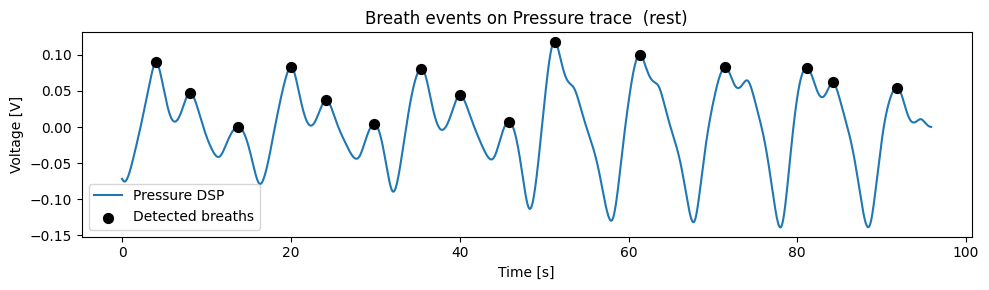

Mean BPM (pressure)      : 9.57


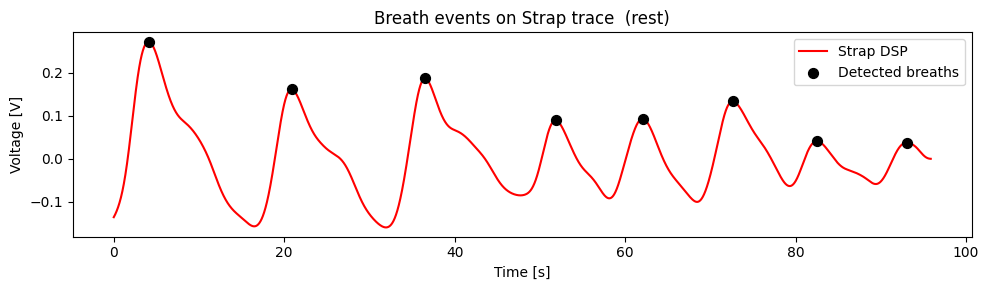

Mean BPM (strap)      : 4.72


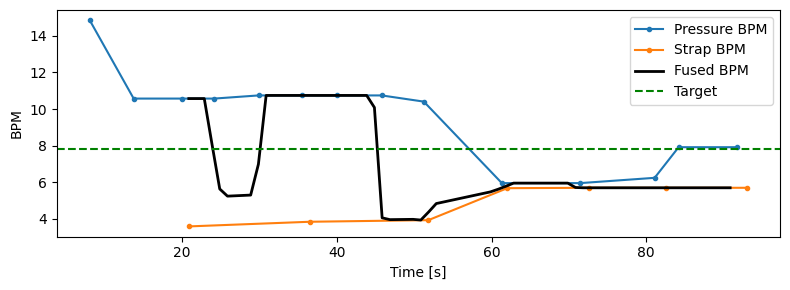

Mean BPM   (fusion)     : 6.78
Saved ► rest_20250526_174003.npz
Meta-index updated.


In [51]:
# Record the two mandatory cases
run_trial('rest',     port='COM4', duration= 96)   # 80 s rest
# run_trial('exercise', port='COM4', duration=30)   # 30s post-exercise (squats)

# # Optional extras
# run_trial('talking', duration=60) # Read aloud for 60s
# run_trial('light',   duration=60) # Walk for 60s
# run_trial('jog', duration=60) # Jog on the spot for 60s

In [2]:
# %% ──────────────────────────────────────────────────────────
# Cell 8 |  OFF-LINE visualisation & metric check for a saved .npz
def analyse_npz(npz_path=None, show_meta=True):
    """
    Load a recording from disk, re-run peak detection,
    show the voltage + BPM plots, and print MSE numbers.

    *npz_path*  – Path or None ==> latest file in DATA_DIR
    """
    # ------- locate file ------------------------------------------------
    if npz_path is None:
        npz_path = sorted(DATA_DIR.glob('*.npz'))[-1]
    elif isinstance(npz_path, str):
        npz_path = pathlib.Path(npz_path)
    d = np.load(npz_path, allow_pickle=True)
    cond = d['cond'].item()
    tgt  = int(d['target_bpm'])
    print(f"\n▶  Analysing {npz_path.name}  (condition = {cond})")

    # ------- pull filtered volts (already band-passed) ------------------
    t  = d['t'];   vP, vS = d['vP'], d['vS']
    # Re-detect peaks for overlay
    bpm_max = int(tgt*1.5)
    tP, bpmP, idxP = breath_rate(vP, invert=True,
                                 bpm_max=bpm_max, return_idx=True)
    tS, bpmS, idxS = breath_rate(vS, invert=False,
                                 bpm_max=bpm_max, return_idx=True)
    tF, bpmF = fuse_bpm(tP, bpmP, tS, bpmS)

    # ------- plots ------------------------------------------------------
    plt.figure(figsize=(10,3))
    plt.plot(t, vP, label='Pressure DSP')
    plt.scatter(t[idxP], vP[idxP], 50, c='k', zorder=3)
    plt.plot(t, vS, label='Strap DSP', alpha=.7)
    plt.scatter(t[idxS], vS[idxS], 50, c='k', zorder=3)
    plt.xlabel('Time [s]'); plt.ylabel('V')
    plt.title(f'{cond} – voltage with detected breaths'); plt.legend()
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(8,3))
    plt.plot(tP, bpmP, '.-', label='Pressure BPM')
    plt.plot(tS, bpmS, '.-', label='Strap BPM')
    plt.plot(tF, bpmF,  'k', lw=2, label='Fused')
    plt.axhline(tgt, ls='--', c='g', label='Target')
    plt.xlabel('Time [s]'); plt.ylabel('BPM'); plt.legend()
    plt.title(f'{cond} – BPM + fusion'); plt.tight_layout(); plt.show()

    # ------- metrics ---------------------------------------------------
    mean_bpmp = d.get('mbpmP', np.mean(bpmP))
    mean_bpms = d.get('mbpmS', np.mean(bpmS))
    mean_bpmF = d.get('mbpmF', np.mean(bpmF))
    print(f"Mean BPM:  Pressure={mean_bpmp:.2f}  Strap={mean_bpms:.2f}  Fusion={mean_bpmF:.2f}")
    # ------- recompute MSE  (sanity) -----------------------------------
    mseP_new = np.mean((bpmP - tgt)**2)
    mseS_new = np.mean((bpmS - tgt)**2)
    mseF_new = np.mean((bpmF - tgt)**2)
    print(f"Stored  MSE  P={d['mseP']:.2f}  S={d['mseS']:.2f}  F={d['mseF']:.2f}")
    print(f"Re-calc MSE  P={mseP_new:.2f}  S={mseS_new:.2f}  F={mseF_new:.2f}")

    # ------- optionally show whole meta table --------------------------
    if show_meta and META_CSV.exists():
        meta = pd.read_csv(META_CSV)
        display(meta)              # Jupyter will render a nice table


▶  Analysing rest_20250526_154419.npz  (condition = rest)


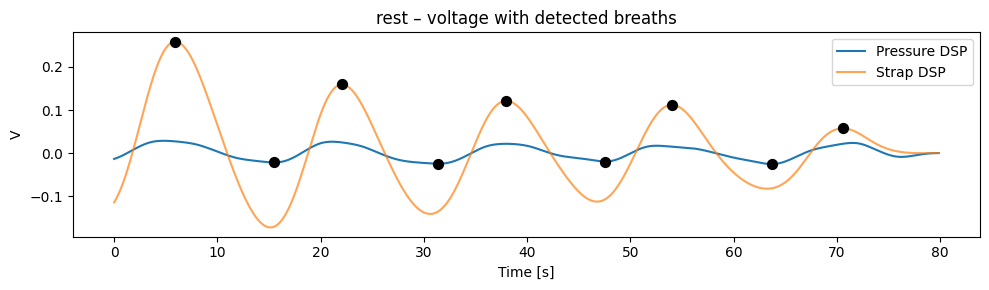

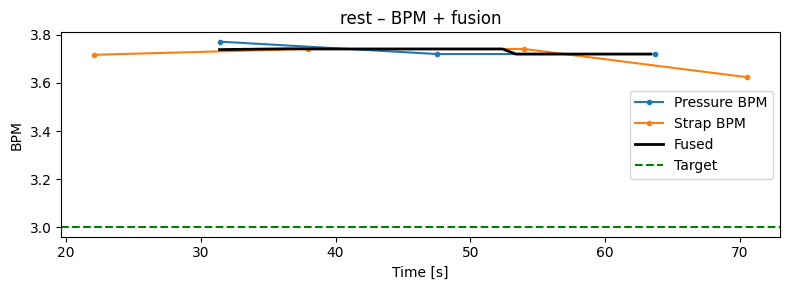

Mean BPM:  Pressure=3.74  Strap=3.71  Fusion=3.73
Stored  MSE  P=0.00  S=0.00  F=0.00
Re-calc MSE  P=0.54  S=0.50  F=0.54


In [12]:
# EXAMPLE USE ------------------------------------------------------------
# analyse_npz()                 # open the most recent run
analyse_npz('project3_data/rest_20250526_154419.npz', show_meta=False)